# NLP

## Modeling

    imports

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import joblib

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, plot_roc_curve,\
confusion_matrix, plot_confusion_matrix, classification_report

from xgboost import XGBClassifier, XGBRFClassifier

    read

In [5]:
dep_model = pd.read_csv("../data/r_depression_data/engineered_depression_data.csv")
anx_model = pd.read_csv("../data/r_anxiety_data/engineered_anxiety_data.csv")

In [6]:
dep_model.shape, anx_model.shape

((188011, 12), (226184, 12))

    train-test

In [7]:
# downsample each dataframe to balance classes 50-50
dep = pd.DataFrame(dep_model[["text", "subreddit"]].sample(188000, replace=False, random_state=137))
anx = pd.DataFrame(anx_model[["text", "subreddit"]].sample(188000, replace=False, random_state=137))

# merge dataframes into single labeled corpus for supervised modeling
model_data = pd.concat([dep, anx])
# encode string labels as integer
model_data["target"] = model_data["subreddit"].map({"depression" : 1, "Anxiety" : 0})

In [8]:
# X corpus of documents
X = model_data["text"]
# encoded labels of subreddit 
y = model_data["target"]

# baseline is 50-50
y.value_counts(normalize = 1)

0    0.5
1    0.5
Name: target, dtype: float64

In [9]:
# Train - test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, shuffle=True, stratify=y, random_state=137)

In [10]:
# we carry our list of stopswords over from preprocessing so our exported/pickled pipelined model
# will remove those stop words from user input
# this causes a warning message to appear about minor inconsistencies between stopword lists
do_not_pass_go = ['up', 'me', 'which', 'her', 'although', 'afterwards', 'can', 'below', 'couldnt', 'co', 'sometimes',
'must', 'whither', "that'll", 'weren', 'will', "wasn't", "wouldn't", 'such', 'somewhere', 'amoungst',
'whereafter', 'into', 'is', 'themselves', 'in', 'at', 'hereupon', 'only', 'top', 'becomes', 'they',
"shouldn't", 'it', 'whoever', 'meanwhile', 'keep', 'haven', 'among', 'with', 'next', 'three', 'as',
'above', 'has', 'none', 'less', 're', 'been', 'former', 'third', 'wasn', 'may', 'being', 'anyway',
'had', 'somehow', 'whenever', 'won', 'where', 'get', 'across', "it's", 'least', "you'd", 'many',
"haven't", 'm', 'during', 'might', 'we', 'didn', 'myself', 'via', 'again', 'sometime', 'put', 'that',
'beforehand', 'much', "aren't", 'anyhow', 'everything', 'last', 'seems', 'and', 'inc', 'other',
'still', 'whence', 'more', 'rather', 'side', 'due', 'per', 'thin', 'shan', 'thereupon', 'isn', 'us',
'anyone', 'mine', 'seem', 'all', 'toward', 'own', 'when', 'thick', 'became', 'eg', 'down', 'him',
'done', 'beside', 'fire', 'same', 'were', 'about', 'ourselves', 'shouldn', 'find', "hasn't", 'un',
'sixty', 'hundred', 'ie', 'nor', 'hers', 'now', 'wherein', 'hereafter', 'whom', 'yourselves',
"mightn't", 'two', 'whose', 'around', 'enough', 'very', "won't", 'always', "don't", 'an', 'cant',
'amongst', 'while', 'found', 'never', 'what', 'etc', 'having', 'most', 'ten', 'bill', 'along', 'be',
'herein', 'without', "shan't", 'five', "you'll", 'become', 'one', "you've", 'even', 'call', 'show',
'another', 'thereafter', 'mill', 'off', 'thence', 'something', 'couldn', 'but', 'cannot', "weren't",
'hadn', 'mostly', 't', 'however', 'con', 'not', 'nevertheless', 'nowhere', 'why', 'anywhere', 'thus',
'anything', 'further', 'doesn', 'after', 'nothing', 'sincere', "didn't", 'o', 'i', 'have', 'nobody', 'do',
'of', "mustn't", 'elsewhere', 'don', 'could', 'them', 'those', 'whatever', 'empty', 'thru', 'noone',
'your', 'for', 'herself', 'yourself', 'hence', 'their', 'thereby', 'latterly', 'six', 'was', 'our',
'formerly', 'any', 'needn', 'these', 'moreover', 'take', "she's", 'few', 'from', 'did', 'often',
'forty', "couldn't", 'aren', 'bottom', 'perhaps', "hadn't", 'twelve', 'others', 'name', 'then',
'made', 'my', 'than', 'already', "should've", 'since', 'theirs', 'wherever', 'therein', 'between',
'some', 'full', 'neither', 'go', 'ours', 'first', 'amount', 'doing', "doesn't", 'whereby',
'several', 'yet', 'there', 'twenty', 'interest', 'front', 'namely', 'therefore', 'no', 'hereby',
'under', 'throughout', 'the', 'just', 'against', 'hasnt', 'eleven', 'once', 'by', 'describe',
'does', 'every', 'this', 'wouldn', 'eight', 'yours', "isn't", 'de', 'within', 'so', 'behind',
'either', 'cry', 'on', 'else', 'ever', 'until', 'latter', 'whether', 'nine', 'to', 'seeming',
'each', 'how', 'himself', 'before', 'beyond', 'alone', 'its', 'hasn', 've', 'towards', 'you',
'detail', 'except', 'though', 'itself', 'he', 'system', 'who', 'ma', 'are', 'or', 'here', "you're",
'someone', 'give', 'serious', 'mightn', 'everywhere', 'upon', 'over', 'also', 'his', 'too', 'together',
'both', 'fifteen', 'seemed', 'fill', 's', 'ain', 'whereupon', 'becoming', 'would', 'd', 'otherwise',
'should', 'y', 'she', 'onto', 'see', 'almost', 'back', 'well', 'fifty', 'whole', 'part', "needn't",
'everyone', 'indeed', 'four', 'out', 'am', 'through', 'ltd', 'move', 'mustn', 'besides', 'if', 'll',
'please', 'whereas', 'because', 'a', "ve", "youtube", "youtube com", '00', '000', '10 15', '10 days',
 '10 hours', '10 minutes', '10 months', '10 times', '95', '99', 'youtube videos',  'www reddit',
"www", "http", "https", "reddit", "subreddit", "r", "youtube com", "youtu", "youtube"]

### Deployed Models

    Model Comparison and Hyperparameter Tuning

In [ ]:
# Matrix representations are unused. All models are run with pipelines and gridsearches.
# tfidf = TfidfVectorizer(
#     stop_words = do_not_pass_go,
#     min_df = .001,
#     max_df = 1.0,
#     ngram_range = (1,2)
# )
# tfidf.fit(X_train)

# tf_matrix = tfidf.transform(X_train)
# tf_matrix_df = pd.DataFrame(tf_matrix.todense(), columns=tfidf.get_feature_names())
# tf_matrix_df

    Multinomial Naive Bayes

In [28]:
# A gridsearch over select hyperparameters for count vectorizer and multinomial naive bayes
# uncomment to run ~ 1 hr. + run time
# %%time
# pipe = Pipeline(
#     [
#         ("cv", CountVectorizer()),
#         ("nb", MultinomialNB())
#     ]
# )

# params = {
#     "cv__stop_words"   : [do_not_pass_go],
#     "cv__max_features" : [5000, 10000],
#     "cv__min_df"       : [0.0001, 0.001],
#     "cv__max_df"       : [0.995, 1.0],
#     "cv__ngram_range"  : [(1,1), (1,2), (1,3)],
#     "nb__alpha"        : [0.2, 1.0, 5.0]
# }

# gs_nb = GridSearchCV(
#     pipe,
#     param_grid=params,
#     cv = 3,
#     n_jobs = 7
# )

# gs_nb.fit(X_train, y_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Wall time: 12min 50s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cv', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cv__max_df': [0.995, 1.0],
                         'cv__max_features': [5000, 10000],
                         'cv__min_df': [0.0001, 0.001],
                         'cv__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'cv__stop_words': [frozenset({'a', 'about', 'above',
                                                       'across', 'after',
                                                       'afterwards', 'again',
                                                       'against', 'ain', 'all',
                                                       'almost', 'alone',
                                                       'along', 'already',
                                                       'also', 'although',
                                                    

In [34]:
# pickle best model
joblib.dump(gs_nb.best_estimator_, "../models/best_nb_model_188.pkl", compress=0)

['../models/best_nb_model.pkl']

In [21]:
# unpickle best model
best_nb = joblib.load("../models/best_nb_model.pkl")

In [10]:
# pipeline of naivebayes model using hyperparameters found by gridsearch
# runtime ~ 30 seconds+
%%time
pipe = Pipeline(
    [
        ("cv", CountVectorizer(
            stop_words   = do_not_pass_go,
            max_features = 10000,
            min_df       = 0.0001,
            ngram_range  = (1, 2))),
        
        ("nb", MultinomialNB(alpha=5))
    ]
)

pipe.fit(X_train, y_train),
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

C:\Users\mjwjl\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '15', 'com', 'days', 'hours', 'minutes', 'months', 'times', 'videos'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 1min 23s


(0.8761129296235679, 0.8737689969604864)

Delta between train and test accuracy is ~ .25% this is well fit naive bayes model.

In [ ]:
# pickle this model
joblib.dump(pipe, "../models/best_nb_model_try.pkl", compress=0)

In [104]:
y_hat_test = pipe.predict(X_test)

recall_score(y_test, y_hat_test), precision_score(y_test, y_hat_test)

(0.8931155015197568, 0.8605001903534718)

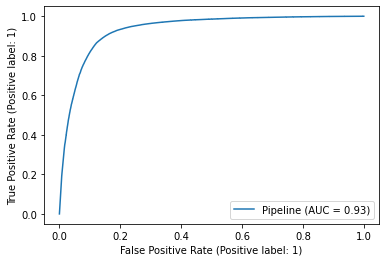

In [105]:
plot_roc_curve(pipe, X_test, y_test)

These metrics examine relations between true positives and type I type II errors. Our model will be deployed to a medical application. We should optimize for precision, minimize type I error. A machine assitant in a medical setting is supplementary. Type I error(false positive) for the user of a mental health app could act as a positive feedback loop, exacerbating their condition.

    Logistic Regression

In [217]:
# Gridsearch over logistic regression model for select hyperparameters
# runtime ~ 3 hrs. 40 mins don't run unpickle model
# %%time
# pipe = Pipeline(
#     [
#         ("tf", TfidfVectorizer()),
#         ("logit", LogisticRegression(max_iter=1000))
#     ]
# )

# params = {
#     "tf__max_features" : [5000, 10000],
#     "tf__min_df"       : [0.001, 0.0001],
#     "tf__max_df"       : [0.995, 1.0],
#     "tf__ngram_range"  : [(1,1), (1,2), (1,3)],
#     "logit__solver"    : ["liblinear"],
#     "logit__penalty"   : [None, "l1", "l2"],
#     "logit__C"         : [0.1, 1, 10]
# }

# gs_logit = GridSearchCV(
#     pipe,
#     param_grid=params,
#     cv = 3,
#     n_jobs = 7
# )

# gs_logit.fit(X_train, y_train)

C:\Users\mjwjl\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.89806465 0.89855974 0.89855974 0.89805237 0.89863339 0.89868249
 0.89806056 0.89780278 0.89781915 0.89724632 0.89761048 0.89764321
 0.89805646 0.8985761  0.89855565 0.89804828 0.89863748 0.8986784
 0.89806056 0.89780278 0.89781097 0.89725041 0.89761866 0.89763912
 0.90353928 0.90425941 0.90429624 0.90366203 0.90436579 0.90434943
 0.90353928 0.90445172 0.90436989 0.90373977 0.90457856 0.9045581
 0.90353928 0.90425941 0.90429624 0.90366203 0.90436579 0.90434943
 0.90353928 0.90445172 0.90436989 0.90373977 0.90457856 0.9045581
        nan        nan        nan        nan        nan 

Wall time: 3h 40min 53s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tf', TfidfVectorizer()),
                                       ('logit',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=7,
             param_grid={'logit__C': [0.1, 1, 10],
                         'logit__penalty': [None, 'l1', 'l2'],
                         'logit__solver': ['liblinear'],
                         'tf__max_df': [0.995, 1.0],
                         'tf__max_features': [5000, 10000],
                         'tf__min_df': [0.001, 0.0001],
                         'tf__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [219]:
gs_logit.best_params_

{'logit__C': 1,
 'logit__penalty': 'l1',
 'logit__solver': 'liblinear',
 'tf__max_df': 0.995,
 'tf__max_features': 10000,
 'tf__min_df': 0.0001,
 'tf__ngram_range': (1, 2)}

{'logit__C': 1,
 'logit__penalty': 'l1',
 'logit__solver': 'liblinear',
 'tf__max_df': 0.995,
 'tf__max_features': 10000,
 'tf__min_df': 0.0001,
 'tf__ngram_range': (1, 2)}

In [223]:
#pickle best logitistic regression model
joblib.dump(gs_logit.best_estimator_, "../models/best_logit_model_188.pkl", compress=0)

['../models/best_logit_model_188.pkl']

In [3]:
# unpickle best logistic regression model
best_logit_model = joblib.load("../models/best_logit_model_188.pkl")

In [41]:
# delta between train and test accuray ~ .009% this is a well fit model
best_logit_model.score(X_train, y_train), best_logit_model.score(X_test, y_test)

(0.9191775777414075, 0.9108282674772037)

In [12]:
y_hat_test = best_logit_model.predict(X_test)

recall_score(y_test, y_hat_test), precision_score(y_test, y_hat_test)

(0.9278267477203648, 0.8973205755691755)

<Figure size 1152x648 with 0 Axes>

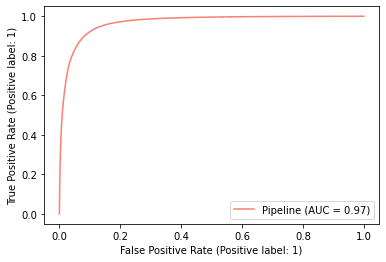

In [42]:
plot_roc_curve(best_logit_model, X_test, y_test, color="salmon")

These metrics examine relations between true positives and type I type II errors. Our model will be deployed to a medical application. We should optimize for precision, minimize type I error. A machine assitant in a medical setting is supplementary. Type I error(false positive) for the user of a mental health app could act as a positive feedback loop, exacerbating their condition.

For the logit model their is an increase is precision, but the threshold would have to be adjusted to tune toward improved precision.

In [14]:
feature_coefficient_df = pd.DataFrame(list(zip(best_logit_model[0].get_feature_names(), best_logit_model[1].coef_.ravel())), columns=["Feature", "Coefficients"]).sort_values(by="Coefficients")

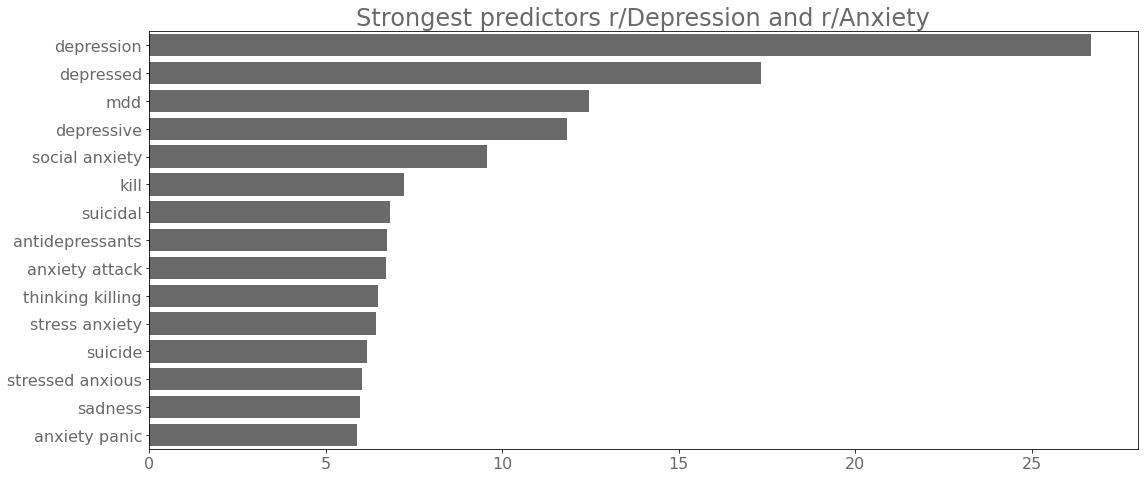

In [83]:
plt.figure(figsize=(16,6.75))
sns.barplot(x = feature_coefficient_df.sort_values(ascending=False, by="Coefficients")["Coefficients"][0:15],
            y = feature_coefficient_df.sort_values(ascending=False, by="Coefficients")["Feature"][0:15], color="dimgrey")

plt.title("Strongest predictors r/Depression and r/Anxiety", fontsize=24, color="dimgrey")
plt.ylabel("", fontsize=20, color="dimgrey")
plt.xlabel("")
plt.yticks(fontsize=16, color="dimgrey")
plt.xticks(fontsize=16, color="dimgrey");
plt.tight_layout()
plt.savefig("../images/dep_logr_coeffs.png", transparent=True);

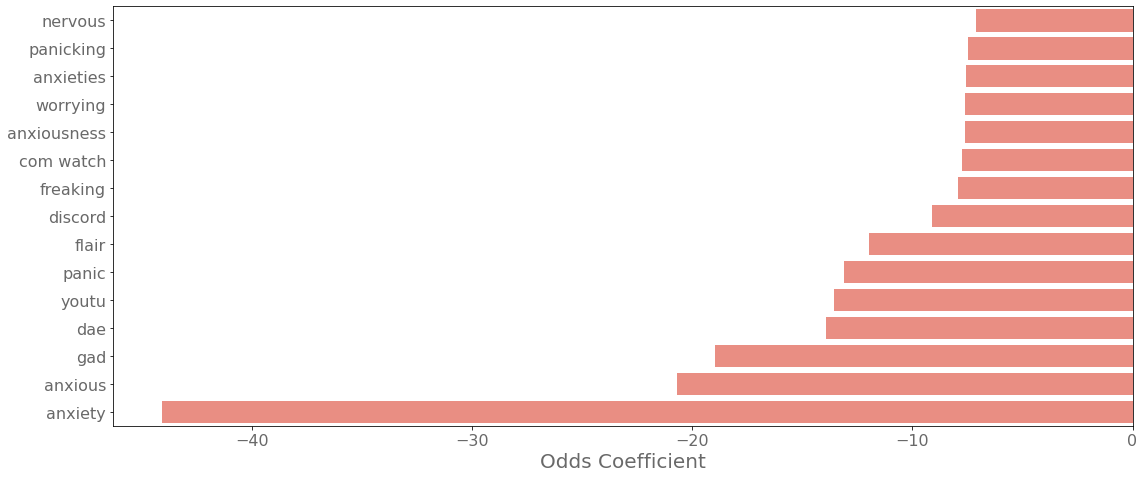

In [84]:
plt.figure(figsize=(16,6.75))
sns.barplot(x = feature_coefficient_df.sort_values(ascending=False, by="Coefficients")["Coefficients"][-15:],
            y = feature_coefficient_df.sort_values(ascending=False, by="Coefficients")["Feature"][-15:], color="salmon")

plt.ylabel("", fontsize=20, color="dimgrey")
plt.xlabel("Odds Coefficient", color="dimgrey", fontsize=20)
plt.yticks(fontsize=16, color="dimgrey")
plt.xticks(fontsize=16, color="dimgrey");
plt.tight_layout()
plt.savefig("../images/anx_logr_coeffs.png", dpi = 300, transparent=True);

Plots of the top 15 predicting features for each class provided as the odds-likely weight for each feature. Further candidates for stop words are noted (e.g. dae "does anyone else"). Future developement would include the removal of all direct mentions of depression and anxiety to better uncover latent features in n-grams. Examining predicting features for each class seperation by lexical item. For example, the hypothesis of the problem statement that depression with possess a "grammar" that is internally and self focused and anxiety with possess a "grammar" that is externally and other focused.

In [45]:
# "manual" experimentation with hyper parameters
%%time
pipe = Pipeline(
    [
        ("tf", TfidfVectorizer(max_features=10000, max_df=0.995, min_df=0.0001, ngram_range= (1,2))),
        ("logit", LogisticRegression(max_iter=1000, solver="liblinear", penalty="l1"))
    ]
)

pipe.fit(X_train, y_train),
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

Wall time: 1min 28s


(0.9193535188216039, 0.9107522796352584)

In [46]:
y_hat_test = pipe.predict(X_test)

recall_score(y_test, y_hat_test), precision_score(y_test, y_hat_test)

(0.9275835866261398, 0.8973755789164155)

In [54]:
print(classification_report(y_hat_test, y_test, target_names=["anxiety", "depression"]))

              precision    recall  f1-score   support

     anxiety       0.89      0.93      0.91     63585
  depression       0.93      0.90      0.91     68015

    accuracy                           0.91    131600
   macro avg       0.91      0.91      0.91    131600
weighted avg       0.91      0.91      0.91    131600



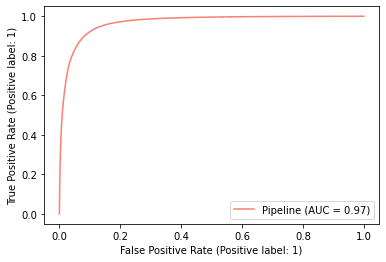

In [55]:
plot_roc_curve(pipe[1], X_test, y_test, color="salmon")

In [58]:
cm = pd.DataFrame(confusion_matrix(y_hat_test, y_test))

plot_confusion_matrix(pipe[1], pipe[0].transform(X_test), y_test, cmap='Pastel1', 
                      values_format=None, display_labels=['r/Anxiety', 'r/Depression'], normalize="true");

### Alternative Models

    SVC and Alternatives

In [ ]:
# SVC is attempted basic model on downsampled data has a runtime ~ 2hrs.
# left here for a time when better computational resources can be accessed
# %%time
# pipe = Pipeline(
#     [
#         ("tf", TfidfVectorizer(max_features=500)),
#         ("sv", SVC(cache_size=5000, kernel="linear"))
#     ]
# )

# pipe.fit(X_train, y_train),
# pipe.score(X_train, y_train), pipe.score(X_test, y_test)

    Linear SVC

In [13]:
# 
%%time
pipe = Pipeline(
    [
        ("tf", TfidfVectorizer(max_features=5000)),
        ("sv", LinearSVC())
    ]
)

pipe.fit(X_train, y_train),
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

Wall time: 30.2 s


(0.9029819969862797, 0.8877695298692118)

In [14]:
y_hat_test = pipe.predict(X_test)

recall_score(y_test, y_hat_test), precision_score(y_test, y_hat_test)

(0.9016956299129597, 0.8729844000583176)

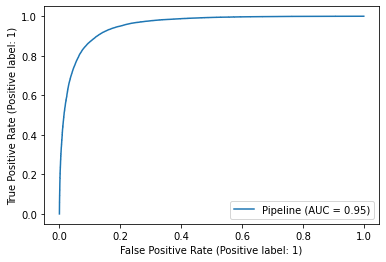

In [15]:
plot_roc_curve(pipe, X_test, y_test)

Linear SVC has lower precision and is slightly overfit when compared to logistic regression models.

    Stochastic Gradient Descent

In [20]:
%%time
pipe = Pipeline(
    [
        ("tf", TfidfVectorizer()),
        ("sg", SGDClassifier())
    ]
)

pipe.fit(X_train, y_train),
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

Wall time: 33 s


(0.8896934570006346, 0.8838982689822639)

In [21]:
y_hat_test = pipe.predict(X_test)

recall_score(y_test, y_hat_test), precision_score(y_test, y_hat_test)

(0.9142955980281934, 0.8590698556298925)

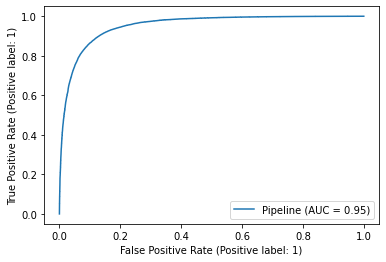

In [22]:
plot_roc_curve(pipe, X_test, y_test)

SGD provides poor precision compared to other models.

    Random Forest

In [17]:
%%time
pipe = Pipeline(
    [
        ("tf", TfidfVectorizer(stop_words = do_not_pass_go, max_features = 5000)),
        ("rf", RandomForestClassifier(n_estimators=200, max_depth=5))
    ]
)

pipe.fit(X_train, y_train),
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

C:\Users\mjwjl\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['10', '15', 'com', 'days', 'hours', 'minutes', 'months', 'times', 'videos'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Wall time: 58.3 s


(0.8688461538461538, 0.8643465045592705)

In [18]:
feature_importance = pd.DataFrame(list(zip(pipe[0].get_feature_names(), pipe[1].feature_importances_.ravel())), columns=["Features", "Importance"])

In [19]:
feature_importance_rf = feature_importance.sort_values(by="Importance", ascending=False).head(50)

In [20]:
feature_importance_rf["Features"][0:10]

279        anxiety
3129         panic
379         attack
2580          life
280        anxious
4337       suicide
1235    depression
381        attacks
2620          live
283        anymore
Name: Features, dtype: object

In [21]:
y_hat_test = pipe.predict(X_test)

recall_score(y_test, y_hat_test), precision_score(y_test, y_hat_test)

(0.9127051671732522, 0.8322155091181198)

The feature importance of forest models would be a useful diagnostic for future developement. These are listed as pecentages, where sum(feature_importances) = 1.

In [60]:
# %%time
# pipe = Pipeline(
#     [
#         ("tf", TfidfVectorizer()),
#         ("rf", RandomForestClassifier(max_depth=None))
#     ]
# )

# pipe.fit(X_train, y_train),
# pipe.score(X_train, y_train), pipe.score(X_test, y_test)

Wall time: 15min 14s


(0.9979048944418532, 0.8566478749236733)

Wall time: 15min 14s

Train Score: 0.9979, Test Score: 0.8566

When max_depth is not set RandomForest severly overfits to the training set.

    XGBoost Random Forest

In [150]:
%%time
pipe = Pipeline(
    [
        ("tf", TfidfVectorizer()),
        ("xgb", XGBClassifier(max_depth=5))
    ]
)

pipe.fit(X_train, y_train),
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

C:\Users\mjwjl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[00:00:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 3min 26s


(0.91310147299509, 0.8958510638297872)

In [21]:
%%time
pipe = Pipeline(
    [
        ("tf", TfidfVectorizer(min_df = 0.0001, max_features=1000)),
        ("xgbrf", XGBRFClassifier(max_depth=5, learning_rate = 0.1))
    ]
)

pipe.fit(X_train, y_train),
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

C:\Users\mjwjl\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:49:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 1min 46s


(0.8441571194762684, 0.8407370820668693)

XGB and XGBRF are left here for future development and experimentation. With very little work or preprocessing these models perform exceedingly well.